In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from hyperopt import Trials, tpe, hp, fmin

import nn
import importlib
importlib.reload(nn)
from keras_utils import run_hyperopt
import conf_utils
import keras.callbacks as kcb
from keras.utils import np_utils
import keras.models as km

import pickle

from joblib import Parallel, delayed
import multiprocessing

sns.set(style='ticks', context='paper')
% config InlineBackend.figure_format = 'svg'

sigmas = np.fliplr(np.exp(pd.read_csv('logsigmas.csv', header=None).values).T)

v3_data = pd.read_csv('v3_data.csv')
cols_to_correct = ['subject', 'resp', 'contrast_id', 'g']

for col in cols_to_correct:
    v3_data[col] = v3_data[col] - 1
    
loo = pd.read_csv('loopsis.csv', header=None).values.T
xent_bayes = -loo[:,2]/2160
xent_quad = -loo[:,6]/2160

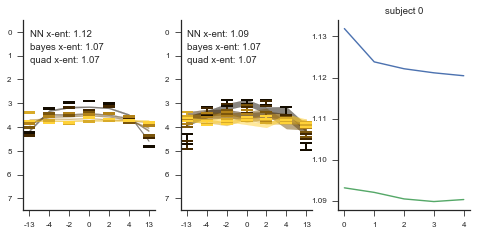

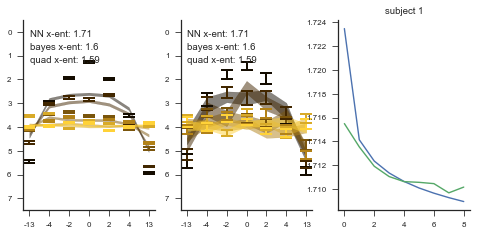

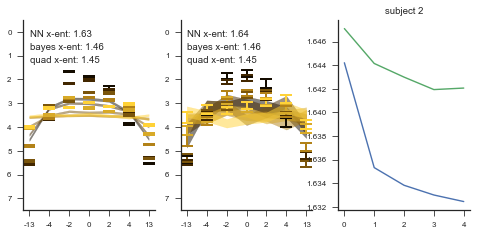

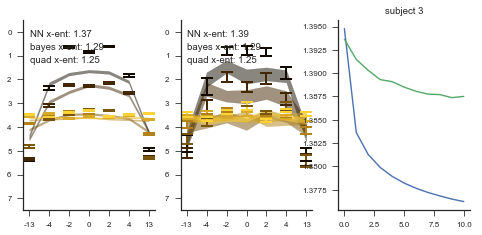

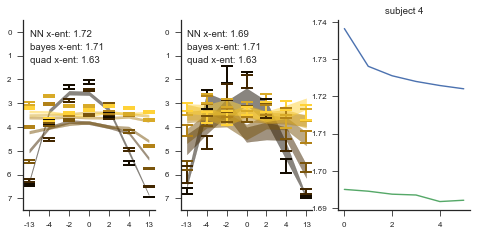

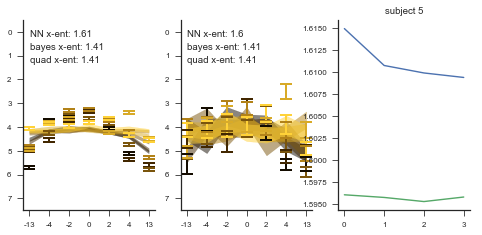

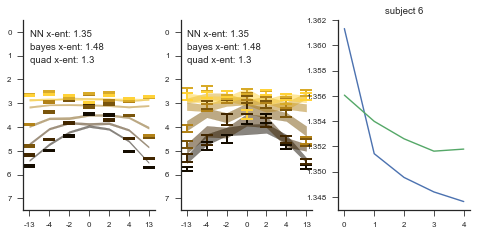

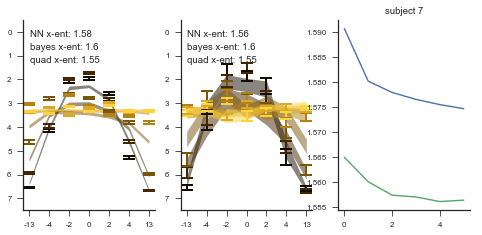

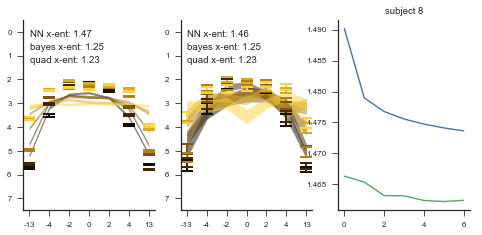

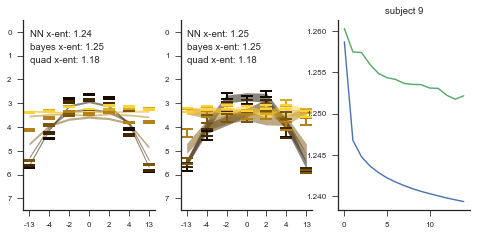

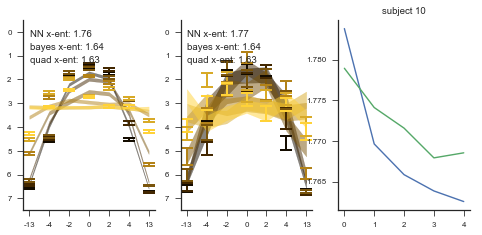

In [28]:
# TRAIN!
importlib.reload(nn)

n_epochs = 15
n_input_neurons = 50
n_train_trials = int(1e6)
c = np.arange(6)

num_cores = 8
    
n_bins = 7

p = {'nhu1': 200,
     'nhu2': 0,
     'optimizer': 'adagrad',
     'l2': 0,
     'n_train': n_train_trials,
     'batch_size': 100,
     'dropout': 0,
     'n_epochs': int(n_epochs)}


def fit_and_plot(subject):
#     n_logged_batches = 1
#     historycallback = nn.NBatchLogger(batch_interval=int(np.max([1, n_train_trials/p['batch_size']/n_logged_batches])))
    stop = kcb.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    df = nn.subject_data(v3_data, subject)
    #     df = df[df['contrast_id'].isin(c)]

    
    x_train, y_train, x_test, y_test, df_train, df_test = nn.data(df, sigmas[subject],
                                                              n_train_trials=n_train_trials,
                                                              baseline=0,
                                                              n_input_neurons=n_input_neurons,
                                                              spref_max=20)

    model, history = nn.fit_nn(p, x_train, y_train, x_test, y_test, callbacks=[stop])
    
    fig, ax = plt.subplots(1,3,figsize=(8,3.5))
    
    score_dict = {'bayes': xent_bayes[subject], 'quad': xent_quad[subject]}
    
    nn.plot_comparison(df_train, x_train, model, ax[0], comparison_score=score_dict, n_bins=n_bins,
                   plot_reliabilities=c)
    
    nn.plot_comparison(df_test, x_test, model, ax[1], comparison_score=score_dict, n_bins=n_bins,
                   plot_reliabilities=c)

    ax[2].plot(history.epoch, history.history['loss'], label='training loss')
    ax[2].plot(history.epoch, history.history['val_loss'], label='validation loss')
    ax[2].set_title('subject {}'.format(subject))
    
    plt.show()

    return model, history
    
model = [None]*11
history = [None]*11
for subject in range(11):
    model[subject], history[subject] = fit_and_plot(subject)
    model[subject].save('1e6{}.h5'.format(subject))

In [6]:
model = [None]*11
for subject in range(11):
    model[subject] = km.load_model('1e6{}.h5'.format(subject))

In [8]:
xent_nn = [1.09, 1.71, 1.64, 1.39, 1.69, 1.6, 1.35, 1.56, 1.46, 1.25, 1.77]

In [31]:
# generate and plot fits
importlib.reload(nn)

c = range(6)
n_input_neurons = 50

n_plot_samples = 20
n_fake_group_datasets = 1000

n_subjects = 11

n_bins = 11
edges, centers = conf_utils.quantile_bins(bins=n_bins)

n_datasets = n_subjects * n_plot_samples

class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value                     # faster to return than dict lookup

spikes = [None]*n_datasets
resp_pred = [None]*n_datasets

trials = [None]*n_datasets

subj_mean_c_s = [None]*n_subjects
subj_mean_c_C = [None]*n_subjects

i = 0

for subject in range(n_subjects):
    df = nn.subject_data(v3_data, subject)
    df = df[df['contrast_id'].isin(c)]
    df['s_bin'] = pd.cut(df['s'], np.concatenate(([-np.inf], edges, [np.inf])), labels=False)
    
    subj_mean_c_s[subject] = df.groupby(['contrast_id', 's_bin'])['resp'].apply(np.mean)
    subj_mean_c_C[subject] = df.groupby(['contrast_id', 'C'])['resp'].apply(np.mean)
#     subj_mean[subject] = c_s_bins['resp'].apply(np.mean)
        
    for dataset in range(n_plot_samples):
        # make flat list of all datasets, then select randomly
        spikes[i] = nn.data(df, sigmas[subject],
                              baseline=0,
                              n_input_neurons=n_input_neurons,
                              spref_max=20,
                              shuffle=False)[0]
        
        resp_pred[i] = np.empty(len(df))
        for j, pvals in enumerate(model[subject].predict(spikes[i])):
            resp_pred[i][j] = np.where(np.random.multinomial(1, pvals=nn._pval_correction(pvals)))[0][0]

        trials[i] = df[['s', 's_bin', 'contrast_id', 'C']]
        
        i += 1
         
grand_subj_mean_c_s = np.array([np.mean([subj_mean_c_s[i][j] for i in range(n_subjects)], axis=0) for j in c])
grand_subj_sem_c_s = np.array([np.std([subj_mean_c_s[i][j] for i in range(n_subjects)], axis=0) for j in c])/np.sqrt(n_subjects)

grand_subj_mean_c_C = np.array([np.mean([subj_mean_c_C[i][j] for i in range(n_subjects)], axis=0) for j in c])
grand_subj_sem_c_C = np.array([np.std([subj_mean_c_C[i][j] for i in range(n_subjects)], axis=0) for j in c])/np.sqrt(n_subjects)

In [32]:
n_fake_group_datasets = 1000
synthetic_sets = [None] * n_fake_group_datasets
synthetic_set_mean_c_s = [None] * n_fake_group_datasets
synthetic_set_mean_c_C = [None] * n_fake_group_datasets


for i in range(n_fake_group_datasets):
    set = np.random.choice(220,11)
    
    synthetic_sets[i] = pd.concat([trials[i] for i in set])
    synthetic_sets[i]['resp_pred'] = np.concatenate([resp_pred[i] for i in set]).astype(int)
    
    synthetic_set_mean_c_s[i] = synthetic_sets[i].groupby(['contrast_id', 's_bin'])['resp_pred'].apply(np.mean)
    synthetic_set_mean_c_C[i] = synthetic_sets[i].groupby(['contrast_id', 'C'])['resp_pred'].apply(np.mean)

grand_nn_mean_c_s = np.array([np.mean([synthetic_set_mean_c_s[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])
grand_nn_std_c_s = np.array([np.std([synthetic_set_mean_c_s[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])

grand_nn_mean_c_C = np.array([np.mean([synthetic_set_mean_c_C[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])
grand_nn_std_c_C = np.array([np.std([synthetic_set_mean_c_C[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])

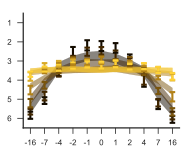

In [35]:
% config InlineBackend.figure_format = 'svg'
contrast_colors =[
    (0.0784,    0.0471,         0),
    (0.2588,    0.1529,         0),
    (0.4784,    0.3333,    0.0471),
    (0.6980,    0.5098,    0.0941),
    (0.8471,    0.6667,    0.1569),
    (1.0000,    0.8235,    0.2196)]

lw = 2.1
capsize = 2.8
fig, ax = plt.subplots(figsize=(2.8,2.11))
for i, contrast in enumerate(c):
    ax.fill_between(range(n_bins), grand_nn_mean_c_s[i] - grand_nn_std_c_s[i],
            grand_nn_mean_c_s[i] + grand_nn_std_c_s[i], color=contrast_colors[contrast], alpha=.5)
    ax.errorbar(range(n_bins), grand_subj_mean_c_s[i], grand_subj_sem_c_s[i],
                ecolor=contrast_colors[contrast],
                capsize=capsize, capthick=lw, elinewidth=lw,
                fmt='none')


# ax.invert_yaxis()

ax.set_xticks(range(n_bins))
ax.set_xticklabels(np.round(centers).astype(int))
ax.set_yticks(range(8))
ax.set_ylim((6.5,0.5))
sns.despine()

# fig.savefig('bla.pdf')

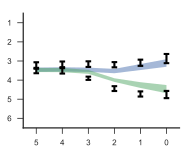

In [79]:
% config InlineBackend.figure_format = 'svg'
contrast_colors =[
    (0.0784,    0.0471,         0),
    (0.2588,    0.1529,         0),
    (0.4784,    0.3333,    0.0471),
    (0.6980,    0.5098,    0.0941),
    (0.8471,    0.6667,    0.1569),
    (1.0000,    0.8235,    0.2196)]

lw = 2.1
capsize = 2.8
fig, ax = plt.subplots(figsize=(2.8,2.11))
for i in range(2):
    ax.fill_between(c, grand_nn_mean_c_C[:,i] - grand_nn_std_c_C[:,i],
            grand_nn_mean_c_C[:,i] + grand_nn_std_c_C[:,i], alpha=.5)
    ax.errorbar(c, grand_subj_mean_c_C[:,i], grand_subj_sem_c_C[:,i],
                ecolor='k',
                capsize=capsize, capthick=lw, elinewidth=lw,
                fmt='none')

ax.set_xlim((5.5, -0.5))
ax.set_xticks(np.arange(6))
ax.set_ylim((6.5, 0.5))
# ax.set_yticks(c)
sns.despine()

fig.savefig('c_C.pdf')

In [53]:
np.flipud(c)

array([5, 4, 3, 2, 1, 0])

In [450]:
print(np.sum(xent_nn*2160)) # sum of x-ent NN
print(np.sum(xent_quad*2160)) # LOO_Quad
print(np.sum(xent_bayes*2160)) # LOO_Bayes

35661.6
33040.7
34042.3


 32/366 [=>............................] - ETA: 18s

,subject,stimtype,task,s,contrast_id,Chat,g,tf,resp,rt,s_bin,resp_pred
47158,10,ellipse,B,-13.247200,0,-1,3,0,0,0.340374,0,7
45537,10,ellipse,B,1.659300,0,-1,3,1,0,0.605094,4,6
46775,10,ellipse,B,1.434320,0,-1,0,1,3,0.787684,4,6
46881,10,ellipse,B,-0.662784,0,-1,0,1,3,0.611244,3,0
45676,10,ellipse,B,2.450820,0,-1,2,1,1,1.263070,4,6
46703,10,ellipse,B,4.059110,0,1,2,0,6,0.534259,5,6
47412,10,ellipse,B,-1.823650,0,1,0,0,4,0.865895,2,7
46894,10,ellipse,B,-17.553200,0,1,3,1,7,0.564476,0,7
46917,10,ellipse,B,-0.352502,0,-1,3,0,0,0.819297,3,0
46691,10,ellipse,B,16.437800,0,1,3,1,7,0.423152,6,6


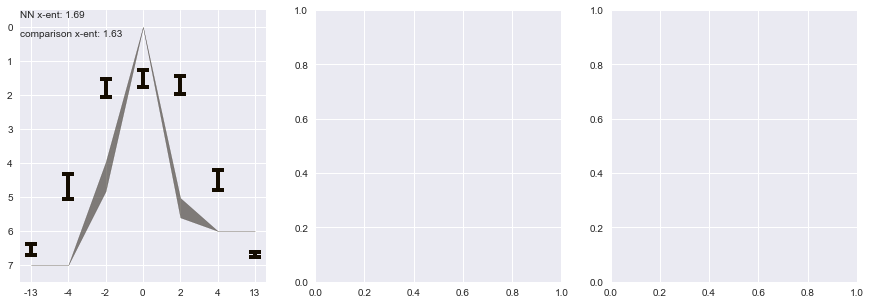

In [422]:
# load subject data

n_subjects = 11
n_input_neurons = 10
n_data_repeat = 2

subject_dicts = [None]*n_subjects

for subject in range(n_subjects):
    x_train, y_train, x_test, y_test, df = nn.data(v3_data, subject, sigmas,
                                                   n_data_repeat=n_data_repeat,
                                                   baseline=0.025,
                                                   n_input_neurons=n_input_neurons)
    subject_dicts[subject] = {'x_train': x_train,
                              'y_train': y_train,
                              'x_test': x_test,
                              'y_test': y_test,
                              'df': df}
    
    
# train on arbitrary params

def params(n_train):
    return {'n_hidden_units': 2000,
        'optimizer': 'adagrad',
        'l2': 0,
        'n_train': int(n_train),
        'batch_size': 10,
        'dropout': 0,
        'n_epochs': 10}

p = params(2160)

subject = 10

d = subject_dicts[subject]

output, model = nn.fit_nn(p, d['x_train'], d['y_train'], d['x_test'], d['y_test'])

fig, ax = plt.subplots(1,2)

nn.plot_comparison(d['df'], d['x_train'], model, ax[0], comparison_score=loo[subject])
nn.plot_comparison(d['df'], d['x_test'], model, ax[1], comparison_score=loo[subject])

2656/4320 [=================>............] - ETA: 0s

/Users/will/Google Drive/Will - Confidence/Analysis/neuralnet2/nn.py:156: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4320 but corresponding boolean dimension is 2160
  return mean, std
/Users/will/Google Drive/Will - Confidence/Analysis/neuralnet2/nn.py:157: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4320 but corresponding boolean dimension is 2160
  


ValueError: Input arrays should have the same number of samples as target arrays. Found 4320 input samples and 2160 target samples.

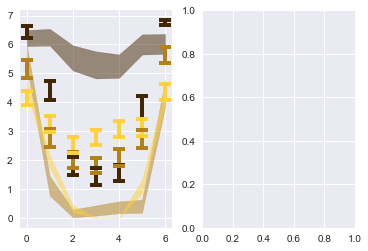

In [95]:
# load subject data

n_subjects = 11
n_input_neurons = 10
n_data_repeat = 2

subject_dicts = [None]*n_subjects

for subject in range(n_subjects):
    x_train, y_train, x_test, y_test, df = nn.data(v3_data, subject, sigmas,
                                                   n_data_repeat=n_data_repeat,
                                                   baseline=0.025,
                                                   n_input_neurons=n_input_neurons)
    subject_dicts[subject] = {'x_train': x_train,
                              'y_train': y_train,
                              'x_test': x_test,
                              'y_test': y_test,
                              'df': df}
    
    
# train on arbitrary params

def params(n_train):
    return {'n_hidden_units': 2000,
        'optimizer': 'adagrad',
        'l2': 0,
        'n_train': int(n_train),
        'batch_size': 10,
        'dropout': 0,
        'n_epochs': 10}

p = params(2160)

subject = 10

d = subject_dicts[subject]

output, model = nn.fit_nn(p, d['x_train'], d['y_train'], d['x_test'], d['y_test'])

fig, ax = plt.subplots(1,2)

nn.plot_comparison(d['df'], d['x_train'], model, ax[0], comparison_score=loo[subject])
nn.plot_comparison(d['df'], d['x_test'], model, ax[1], comparison_score=loo[subject])

Todo:
    
use hyperopt to optimize hyper-parameters: dropout, optimizer, n hidden units, etc
add l2 regularization
get running on cluster

see what happens if you increase gains. do fits get better? they do. but why does adam take longer if there are more spikes?
check if task performance is roughly matched for subject and network

ordinal multiclassification. cardoso 2007


subjects with high performance and low noise: 2, 8, 10
subjects that use every button: 1, 3, 4, 7, 10
use subject 10
subject 2 has very low lapse
load in the probabilities predicted by model and subject

In [27]:
# load hyperparameters fitted on cluster

trials = [None] * n_subjects
for subject in range(n_subjects):
    trials[subject] = pickle.load(open('trials{:02}.p'.format(subject), 'rb'))
    
def convert_params(trial_vals):
    p = {i: trial_vals[i][0] for i in trial_vals}
    p['optimizer'] = ['adadelta', 'adagrad'][p['optimizer']]
    return p

hyperparams = [None] * 11

for subject in range(11):
    hyperparams[subject] = convert_params(trials[subject].best_trial['misc']['vals'])

{'batch_size': 10.0,
 'dropout': 0.22222978257750353,
 'l2': 1.970253921365814e-08,
 'n_hidden_units': 181.0,
 'n_train': 592849.0,
 'optimizer': 'adadelta'}

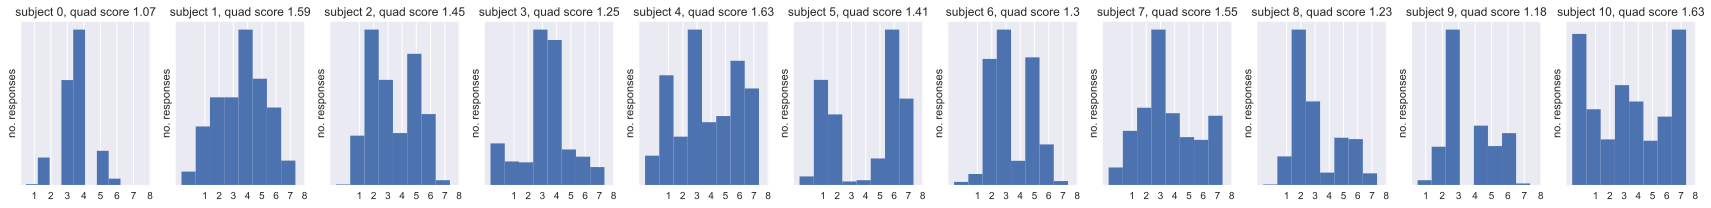

In [30]:
ax = plt.subplots(1,11,figsize=(30,3))
for subject in range(11):
    ax[1][subject].hist(nn.subject_data(v3_data, subject)['resp'],8)
    ax[1][subject].set_xticks(np.linspace(1.4375,7.5625,8))
    ax[1][subject].set_xticklabels(np.arange(8)+1)
    ax[1][subject].set_yticks([])
    ax[1][subject].set_ylabel('no. responses')
    ax[1][subject].set_title('subject {}, quad score {:.3}'.format(subject, loo[subject]))

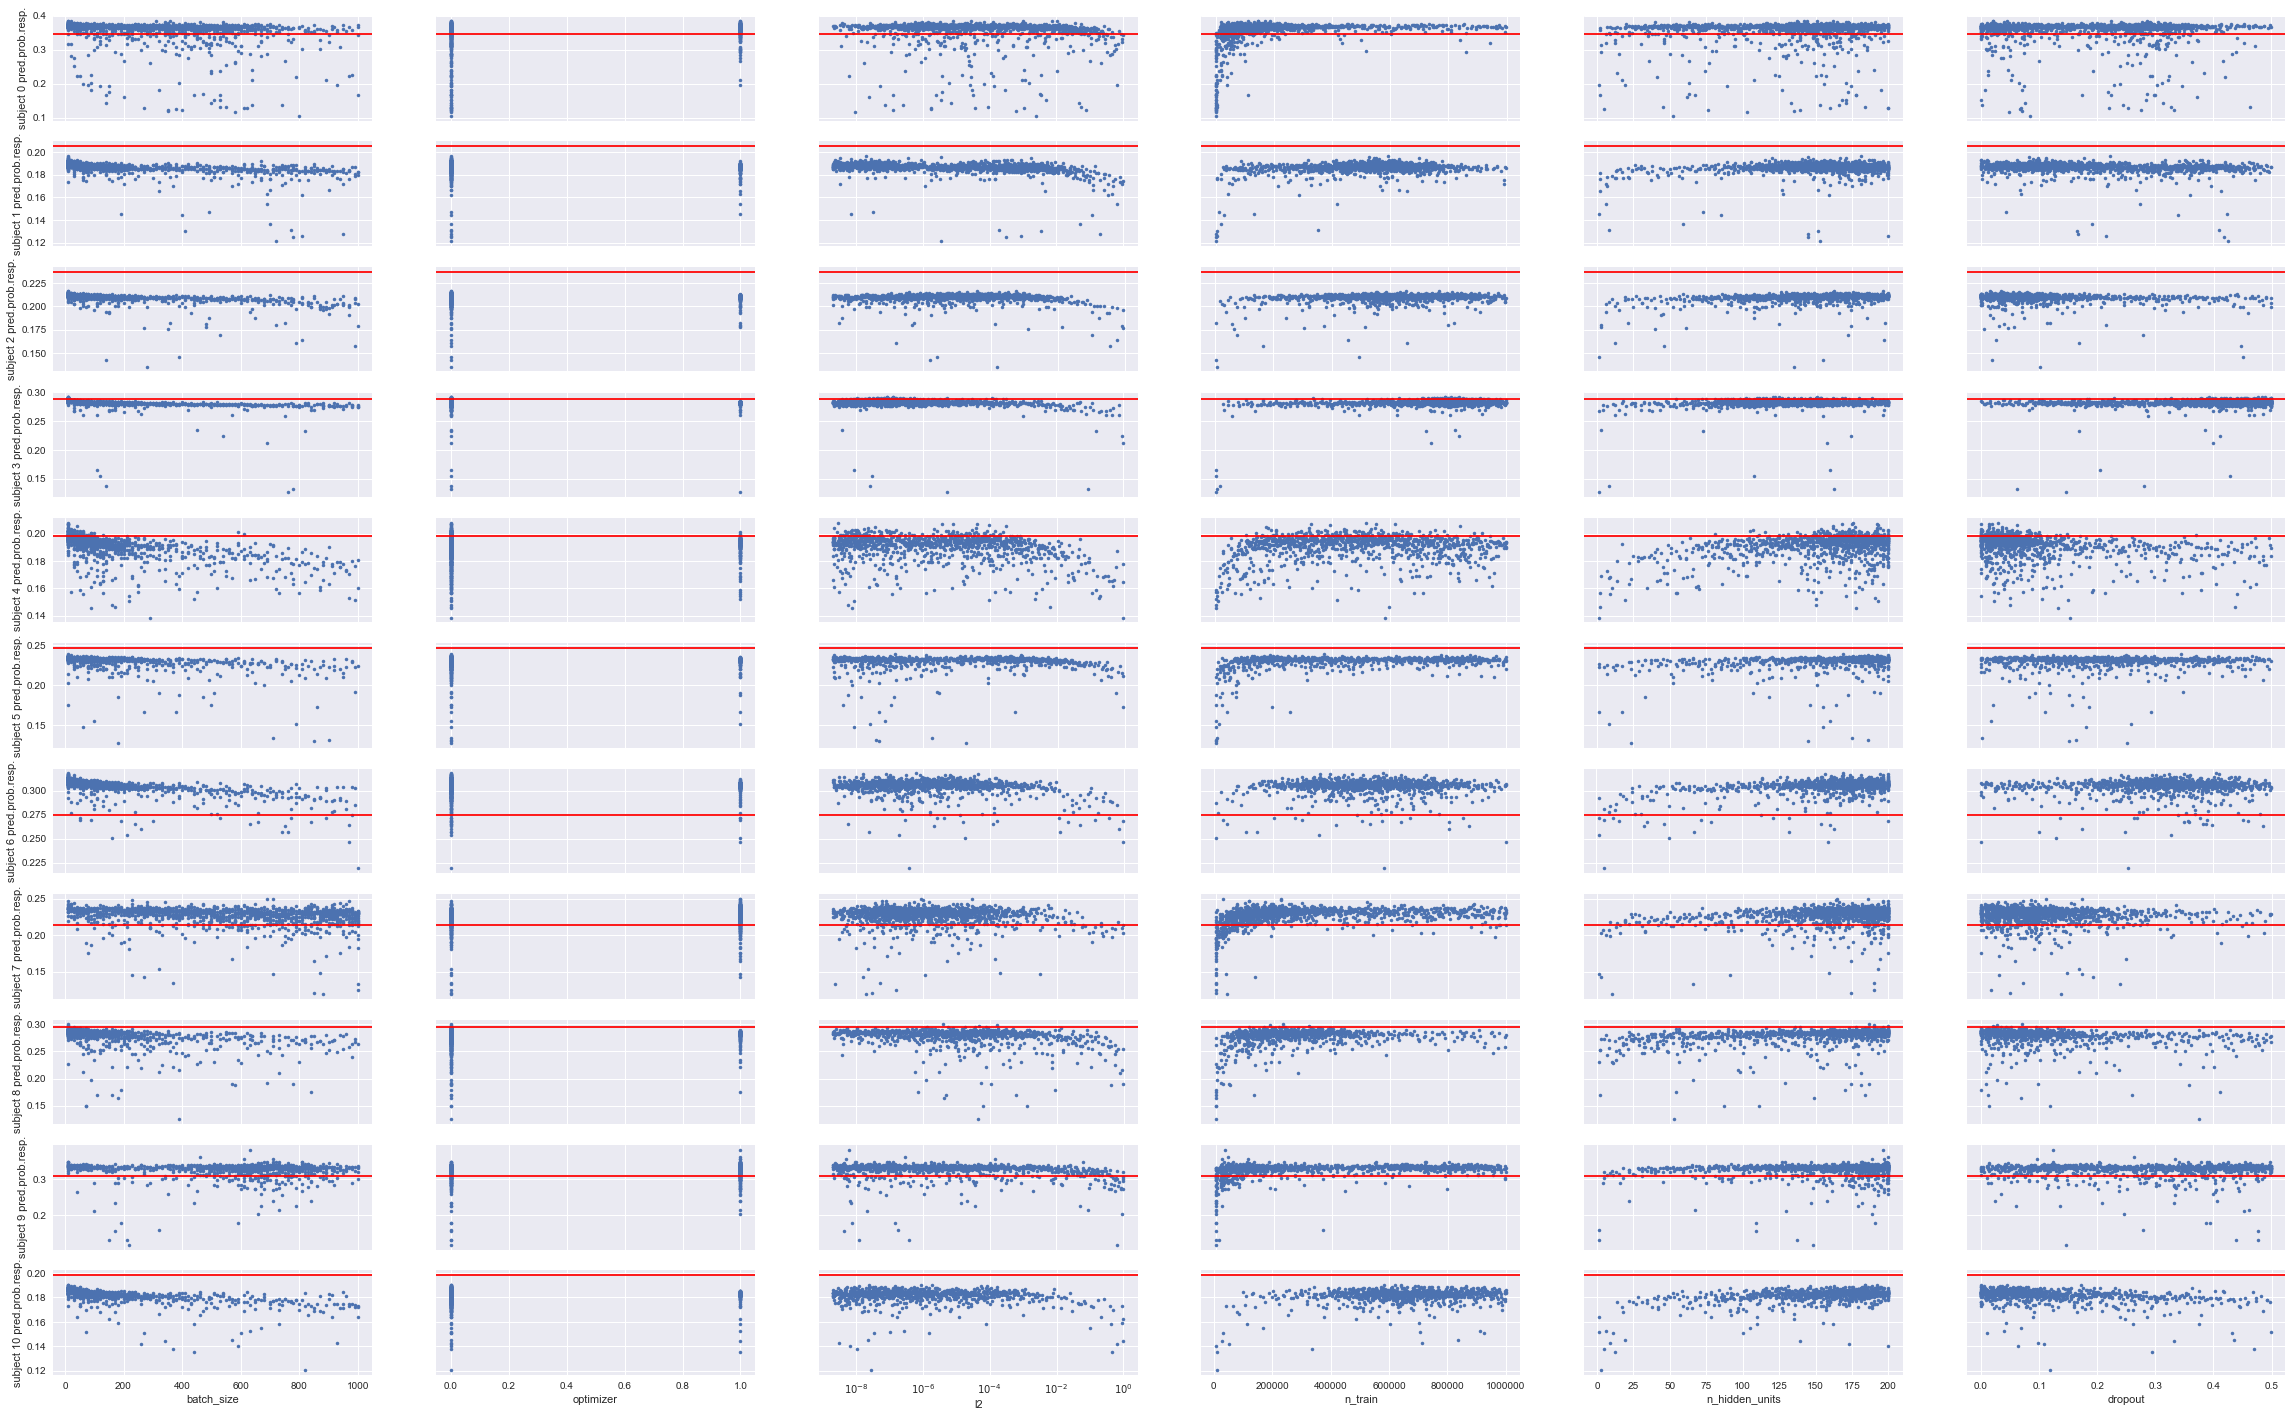

In [10]:
# hyperparameters vs loss for every subject

param_names = ['batch_size', 'optimizer', 'l2', 'n_train', 'n_hidden_units', 'dropout']
n_params = len(param_names)

n_subjects = 11

fig, ax = plt.subplots(n_subjects, n_params, figsize=(40,25))

for subject in range(n_subjects):
    for param, param_name in enumerate(param_names):
        axis = ax[subject, param]
        
        axis.plot(trials[subject].vals[param_name], -np.array(trials[subject].losses()), '.')
        axis.axhline(y=quad_scores[subject], color='r', linestyle='-')
        
        if param==0:
            axis.set_ylabel('subject {} pred.prob.resp.'.format(subject))
        else:
            axis.set_yticklabels('')
            if param_name in ['l2']:
                axis.set_xscale('log')
        
        if subject == 10:
            axis.set_xlabel(param_name)
        else:
            axis.set_xticklabels('')

KeyboardInterrupt: 

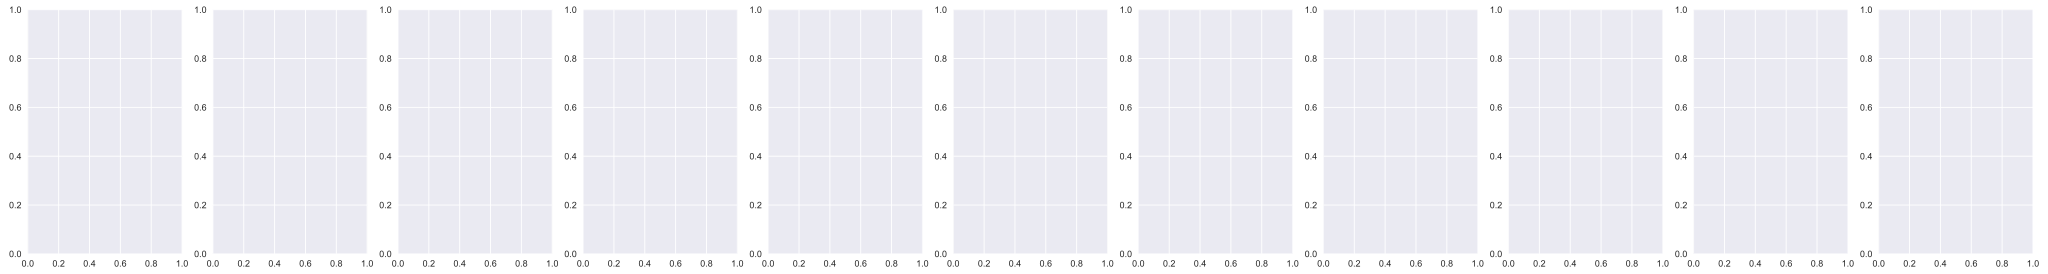

In [35]:
# train on best params

%config InlineBackend.figure_format = 'svg'

importlib.reload(nn)


fig, ax = plt.subplots(1, n_subjects, figsize=(40,5))

for subject in range(n_subjects):
    d = subject_dicts[subject]

    hp = hyperparams[subject]
    
    model = nn.fit_nn(hp, d['x_train'], d['y_train'], d['x_test'], d['y_test'])[1]
    nn.plot_comparison(d['df'], d['x_test'], model, ax[subject], comparison_score=quad_scores[subject])

plt.show()

fig.savefig('bla.pdf')

1792/2160 [=======================>......] - ETA: 0s

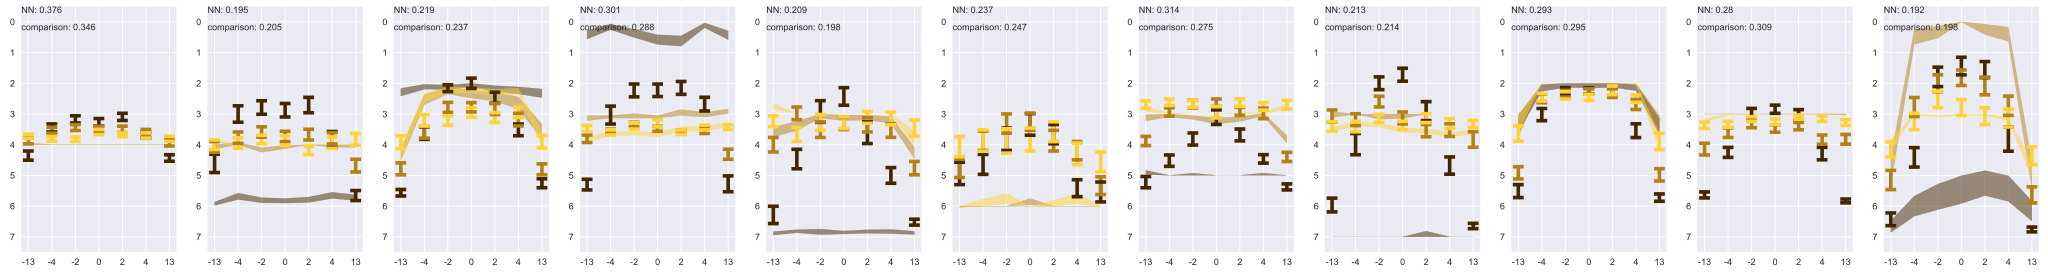

In [144]:
# train on best params, with zero baseline, not as many trials

%config InlineBackend.figure_format = 'svg'

importlib.reload(nn)


fig, ax = plt.subplots(1, n_subjects, figsize=(40,5))

for subject in range(n_subjects):
    d = subject_dicts[subject]

    hp = hyperparams[subject].copy()
    hp['n_train'] = hp['n_train']/3
    
    model = nn.fit_nn(hp, d['x_train'], d['y_train'], d['x_test'], d['y_test'])[1]
    nn.plot_comparison(d['df'], d['x_test'], model, ax[subject], comparison_score=quad_scores[subject])

plt.show()

# fig.savefig('bla.pdf')

2016/2160 [===========================>..] - ETA: 0s

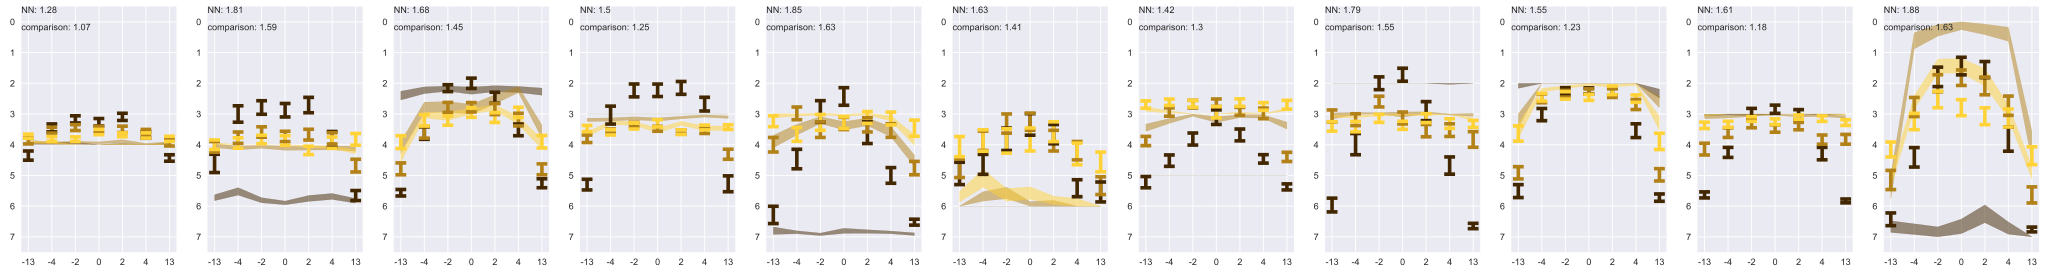

In [32]:
# train on best params, with zero baseline, not as many trials

%config InlineBackend.figure_format = 'svg'

importlib.reload(nn)


fig, ax = plt.subplots(1, n_subjects, figsize=(40,5))

for subject in range(n_subjects):
    d = subject_dicts[subject]

    hp = hyperparams[subject].copy()
    hp['n_train'] = hp['n_train']/20
    
    model = nn.fit_nn(hp, d['x_train'], d['y_train'], d['x_test'], d['y_test'])[1]
    nn.plot_comparison(d['df'], d['x_test'], model, ax[subject], comparison_score=loo[subject])

plt.show()

# fig.savefig('bla.pdf')

- why are the fits so terrible?

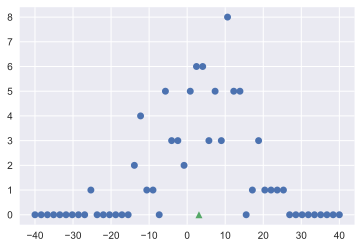

In [289]:
d = subject_dicts[10]

spref = np.linspace(-40,40,50)

idx = d['df']['contrast_id']==5

i = np.random.choice(np.where(idx)[0])

plt.plot(spref,d['x_test'][i],'o')
plt.plot(d['df']['s'].iloc[i],0,'^')

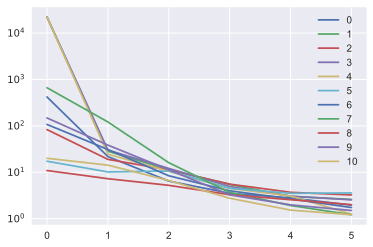

In [134]:
for s in range(len(sigmas)):
    plt.plot(sigmas[s], label=s)
    
plt.yscale('log')
plt.legend()